In [90]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score, cross_validate,StratifiedKFold,GridSearchCV,train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [2]:
df = pd.read_csv("jena_climate_2009_2016.csv")

In [3]:
df

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.10
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.60
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.00
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71768,14.05.2010 09:50:00,983.59,7.52,282.01,4.46,80.9,10.39,8.41,1.98,5.33,8.55,1216.82,0.73,2.00,3.13
71769,14.05.2010 10:00:00,983.65,7.94,282.43,4.44,78.5,10.69,8.40,2.30,5.33,8.53,1215.08,1.69,4.44,32.51
71770,14.05.2010 10:10:00,983.60,7.82,282.31,4.20,77.8,10.61,8.25,2.35,5.24,8.39,1215.61,1.92,3.40,25.92
71771,14.05.2010 10:20:00,983.58,7.85,282.34,4.17,77.5,10.63,8.24,2.39,5.23,8.37,1215.46,1.78,3.68,21.85


In [4]:
df = df[5::6] #TO Show every other hour

In [5]:
# df[5::12]

In [6]:
df.index = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')
df

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,,
2009-01-01 01:00:00,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.70
2009-01-01 02:00:00,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.30
2009-01-01 03:00:00,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.20
2009-01-01 04:00:00,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.00
2009-01-01 05:00:00,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-05-14 06:20:00,14.05.2010 06:20:00,983.50,6.24,280.73,4.34,87.6,9.51,8.33,1.18,5.29,8.47,1222.33,1.81,3.40,19.32
2010-05-14 07:20:00,14.05.2010 07:20:00,983.66,6.30,280.78,4.32,87.1,9.56,8.32,1.23,5.28,8.46,1222.24,2.25,3.48,26.83
2010-05-14 08:20:00,14.05.2010 08:20:00,983.70,6.65,281.13,4.21,84.4,9.79,8.26,1.53,5.24,8.40,1220.82,1.57,2.92,10.44


<Axes: xlabel='Date Time'>

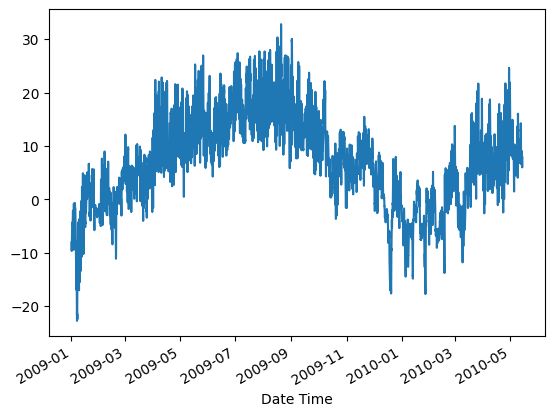

In [7]:
temp = df['T (degC)']
temp.plot()

In [8]:
def create_dataset_bystep(df, step = 5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-step):
    row = [[a] for a in df_as_np[i:i+step]]# the [a] 3lshan n5aly el array msln lw el step 5 el x tb2a[[[1], [2], [3], [4], [5]] w el y msh azma htappend ka vector
    X.append(row)
    label = df_as_np[i+step]
    y.append(label)
  return np.array(X), np.array(y)

In [9]:
steps = 5 # e5tarna 5 steps 3lshan mn el 5 sa3at ely ablyha ypredict el sa3a el 6
X1, y1 = create_dataset_bystep(temp, steps)#temp 3lshan awk3 wa7da 7alyen
X1.shape, y1.shape

((11957, 5, 1), (11957,))

In [10]:
train_size = 65000


X_train1, y_train1 = X1[:train_size], y1[:train_size]
X_test1, y_test1 = X1[train_size:], y1[train_size:]

print("X_train1 shape:", X_train1.shape)
print("y_train1 shape:", y_train1.shape)
print("X_test1 shape:", X_test1.shape)
print("y_test1 shape:", y_test1.shape)

X_train1 shape: (11957, 5, 1)
y_train1 shape: (11957,)
X_test1 shape: (0, 5, 1)
y_test1 shape: (0,)


# Uni-variate

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((5, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
cp1 = ModelCheckpoint('/content/model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [23]:
model1.fit(X_train1, y_train1, epochs=10, callbacks=[cp1])

Epoch 1/10
371/374 [============================>.] - ETA: 0s - loss: 0.6643 - root_mean_squared_error: 0.8150

374/374 [==============================] - 4s 5ms/step - loss: 0.6636 - root_mean_squared_error: 0.8146
Epoch 2/10
374/374 [==============================] - ETA: 0s - loss: 0.6602 - root_mean_squared_error: 0.8125

374/374 [==============================] - 2s 5ms/step - loss: 0.6602 - root_mean_squared_error: 0.8125
Epoch 3/10
370/374 [============================>.] - ETA: 0s - loss: 0.6560 - root_mean_squared_error: 0.8100

374/374 [==============================] - 2s 5ms/step - loss: 0.6585 - root_mean_squared_error: 0.8115
Epoch 4/10
373/374 [============================>.] - ETA: 0s - loss: 0.6548 - root_mean_squared_error: 0.8092

374/374 [==============================] - 2s 6ms/step - loss: 0.6543 - root_mean_squared_error: 0.8089
Epoch 5/10
369/374 [============================>.] - ETA: 0s - loss: 0.6530 - root_mean_squared_error: 0.8081

374/374 [==============================] - 2s 6ms/step - loss: 0.6514 - root_mean_squared_error: 0.8071
Epoch 6/10
364/374 [============================>.] - ETA: 0s - loss: 0.6497 - root_mean_squared_error: 0.8061

374/374 [==============================] - 2s 5ms/step - loss: 0.6486 - root_mean_squared_error: 0.8054
Epoch 7/10
373/374 [============================>.] - ETA: 0s - loss: 0.6484 - root_mean_squared_error: 0.8052

374/374 [==============================] - 2s 5ms/step - loss: 0.6482 - root_mean_squared_error: 0.8051
Epoch 8/10
366/374 [============================>.] - ETA: 0s - loss: 0.6434 - root_mean_squared_error: 0.8021

374/374 [==============================] - 2s 5ms/step - loss: 0.6456 - root_mean_squared_error: 0.8035
Epoch 9/10
366/374 [============================>.] - ETA: 0s - loss: 0.6452 - root_mean_squared_error: 0.8032

374/374 [==============================] - 2s 5ms/step - loss: 0.6438 - root_mean_squared_error: 0.8024
Epoch 10/10
364/374 [============================>.] - ETA: 0s - loss: 0.6484 - root_mean_squared_error: 0.8053

374/374 [==============================] - 2s 5ms/step - loss: 0.6454 - root_mean_squared_error: 0.8034


In [21]:
from tensorflow.keras.models import load_model
lstmUni = load_model('/content/model1')

OSError: SavedModel file does not exist at: /content/model1/{saved_model.pbtxt|saved_model.pb}

In [24]:
train_predictions = model1.predict(X_train1).flatten()#3amlna flatten 3lshan tb2a 1D badel makanet matrix fo2 w tb2a aligned ma3 el actual 3lshan nee3rf ncompare
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

374/374 [==============================] - 2s 3ms/step


,Train Predictions,Actuals
0,-9.789454,-9.67
1,-9.567427,-9.17
2,-8.646053,-8.10
3,-7.154006,-7.66
4,-7.042780,-7.04
...,...,...
11952,6.010167,6.24
11953,6.448213,6.30
11954,6.461451,6.65
11955,6.922523,7.05


In [ ]:
# plt.figure(figsize=(10, 6))
# plt.plot(train_results.index, train_results['Train Predictions'], label='Train Predictions')
# plt.plot(train_results.index, train_results['Actuals'], label='Actuals')
# plt.xlabel('Sample Index')
# plt.ylabel('Value')
# plt.title('Training Predictions vs Actuals')
# plt.legend()
# plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

plt.plot(train_results['Train Predictions'][50:100] , label = 'Train Predictions')
plt.plot(train_results['Actuals'][50:100],label = 'Actual')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.title('Training Predictions vs Actuals between the indeces of 50 and 100')

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error,mean_absolute_percentage_error
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred):
    # Avoid division by zero
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0
    return np.mean(np.abs((y_true[non_zero_indices] - y_pred[non_zero_indices]) / y_true[non_zero_indices])) * 100

# Assuming you have the ground truth values in y_train1 and the predicted values in train_predictions

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_train1, train_predictions)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_train1, train_predictions)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(y_train1, train_predictions)
print("This is based on the train and actual")
print("Mean Absolute Error (MAE): ", mae)
print("Mean Squared Error (MSE): ", mse)
print("Root Mean Squared Error (RMSE): ", rmse)
print("Mean Absolute Percentage Error (MAPE): ", mape)

In [ ]:
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})
test_results

In [ ]:
# plt.plot(val_results['Val Predictions'][:100])
# plt.plot(val_results['Actuals'][:100])
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

plt.plot(test_results['Test Predictions'][:100] , label = 'Test Predictions')
plt.plot(test_results['Actuals'][:100],label = 'Actual')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()

plt.title('Test Predictions vs Actuals for the indeces of the last 100')

In [ ]:
# evaluation_metrics = model1.evaluate(X_train1, y_train1)

# print("Evaluation Metrics:")
# for metric_name, metric_value in zip(model1.metrics_names, evaluation_metrics):
#     print(metric_name + ": ", metric_value)

In [ ]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred):
    # Avoid division by zero
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0
    return np.mean(np.abs((y_true[non_zero_indices] - y_pred[non_zero_indices]) / y_true[non_zero_indices])) * 100

def evaluate_model(y_true, y_pred):
    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_true, y_pred)

    # Mean Squared Error (MSE)
    mse = mean_squared_error(y_true, y_pred)

    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    # Mean Absolute Percentage Error (MAPE)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    print("This is based on the Test and actual")
    print("Mean Absolute Error (MAE): ", mae)
    print("Mean Squared Error (MSE): ", mse)
    print("Root Mean Squared Error (RMSE): ", rmse)
    print("Mean Absolute Percentage Error (MAPE): ", mape)

# Assuming you have the ground truth values in y_test1 and the predicted values in test_predictions
evaluate_model(y_test1, test_predictions)

# CNN

In [ ]:
CNN = Sequential()
CNN.add(InputLayer((5, 1)))
CNN.add(Conv1D(64, kernel_size=2))
CNN.add(Flatten())
CNN.add(Dense(8, 'relu'))
CNN.add(Dense(1, 'linear'))

CNN.summary()

In [ ]:
cp2 = ModelCheckpoint('CNN/', save_best_only=True)
CNN.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
CNN.fit(X_train1, y_train1, epochs=10, callbacks=[cp2])

In [ ]:
cnn_test_predictions = CNN.predict(X_test1).flatten()
cnn_test_results = pd.DataFrame(data={'Test Predictions':cnn_test_predictions, 'Actuals':y_test1})
cnn_test_results

In [ ]:
evaluate_model(y_test1, cnn_test_predictions)

In [ ]:

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

plt.plot(cnn_test_results['Test Predictions'][:100] , label = 'Test Predictions')
plt.plot(cnn_test_results['Actuals'][:100],label = 'Actual')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()

plt.title('Test Predictions vs Actuals for the indeces of the last 100')

# GRU

In [ ]:
model3 = Sequential()
model3.add(InputLayer((5, 1)))
model3.add(GRU(64))
model3.add(Dense(8, 'relu'))
model3.add(Dense(1, 'linear'))
model3.summary()

In [ ]:
cp3 = ModelCheckpoint('GRU/', save_best_only=True)
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
model3.fit(X_train1, y_train1, epochs=10, callbacks=[cp3])

# Multi Variate

In [ ]:
temp_df = pd.DataFrame({'Temperature':temp})
temp_df['Seconds'] = temp_df.index.map(pd.Timestamp.timestamp)
temp_df

In [ ]:
day = 60*60*24
year = 365.2425*day

temp_df['Day sin'] = np.sin(temp_df['Seconds'] * (2* np.pi / day))
temp_df['Day cos'] = np.cos(temp_df['Seconds'] * (2 * np.pi / day))
temp_df['Year sin'] = np.sin(temp_df['Seconds'] * (2 * np.pi / year))
temp_df['Year cos'] = np.cos(temp_df['Seconds'] * (2 * np.pi / year))
temp_df.head()

In [ ]:
temp_df = temp_df.drop('Seconds', axis=1)
temp_df.head()

In [32]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'jena-climate:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1108632%2F1862887%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240601%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240601T194503Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1ebc526d2c825d4f52e61f83aae857d58738567d82899ee5fd3b78c275e88bea87f217180f047adc30fc7f2c497473bace5194bae403b8e33a290de5554aa1fde47b1470556bd7f4ad7d6f8c74b817d1d3ea35ce32fecfd0ed73960657de3814887d6071f9b0f73ebcbf8375329fd376a505a537c9e6ee973419b583ddaf01f5a7f7b4dbd459dff7307e998d1615a774d99fdd3d27db19f6122b461cce36e2ca30acc6717d2bf5dff2f31e7b8a1a9ffe16e6ea0413e38dd03f4094db7dfbc527d76bd919a9dd0c53f68354a692cda46e1376dfb939fba8b28b64b26fc13b2fb97bc13a48b8f5536f422b78c40107532492d0a5e8e28d7523b4cfb22bf3f00b38'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 13827694 bytes downloaded
Downloaded and uncompressed: jena-climate
Data source import complete.


In [55]:
df

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,,
2009-01-01 01:00:00,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.70
2009-01-01 02:00:00,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.30
2009-01-01 03:00:00,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.20
2009-01-01 04:00:00,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.00
2009-01-01 05:00:00,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-05-14 06:20:00,14.05.2010 06:20:00,983.50,6.24,280.73,4.34,87.6,9.51,8.33,1.18,5.29,8.47,1222.33,1.81,3.40,19.32
2010-05-14 07:20:00,14.05.2010 07:20:00,983.66,6.30,280.78,4.32,87.1,9.56,8.32,1.23,5.28,8.46,1222.24,2.25,3.48,26.83
2010-05-14 08:20:00,14.05.2010 08:20:00,983.70,6.65,281.13,4.21,84.4,9.79,8.26,1.53,5.24,8.40,1220.82,1.57,2.92,10.44


In [75]:
df = pd.read_csv("jena_climate_2009_2016.csv")
df['Date Time']=pd.to_datetime(df['Date Time'],format='mixed')

# ubah menjadi hourly dan drop kolom yang tidak diperlukan
df= df[df['Date Time'].dt.minute==0].reset_index(drop=True).drop(columns=['Tpot (K)','Tdew (degC)'])
df.head()

,Date Time,p (mbar),T (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,2009-01-01 01:00:00,996.50,-8.05,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
1,2009-01-01 02:00:00,996.62,-8.88,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2,2009-01-01 03:00:00,996.84,-8.81,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
3,2009-01-01 04:00:00,996.99,-9.05,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
4,2009-01-01 05:00:00,997.46,-9.63,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


In [76]:
input_= df[[i for i in df.columns if i not in ['Date Time']]]
target = df['T (degC)'].to_numpy() # kita akan prediksi Temperatur

# data time series tidak boleh di shuffle. pastikan shuffle = False
X, X_test, y, y_test = train_test_split(input_, target, test_size=0.1, shuffle=False, random_state=2024)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, shuffle=False, random_state=2024)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(53619, 12) (9463, 12) (7010, 12)
(53619,) (9463,) (7010,)


In [77]:
# scaling data
preprocessing= ColumnTransformer([
    ('pipe',make_pipeline(StandardScaler()), list(input_.columns))
    ])

X_train_scaled = preprocessing.fit_transform(X_train)
X_val_scaled = preprocessing.transform(X_val)
X_test_scaled = preprocessing.transform(X_test)

In [78]:
# window = 24. artinya dalam 24 jam, kita mencoba untuk prediksi temperatur 1 jam berikutnya
window_len = 24
batch_size = 16
train_gen = TimeseriesGenerator(data=X_train_scaled, targets=y_train, length=window_len, shuffle=False, batch_size=batch_size)
val_gen = TimeseriesGenerator(data=X_val_scaled, targets=y_val, length=window_len, shuffle=False, batch_size=batch_size)
test_gen=TimeseriesGenerator(data=X_test_scaled, targets=y_test, length=window_len, shuffle=False, batch_size=batch_size)


,p (mbar),T (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,996.50,-8.05,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.70
1,996.62,-8.88,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.30
2,996.84,-8.81,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.20
3,996.99,-9.05,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.00
4,997.46,-9.63,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.00
...,...,...,...,...,...,...,...,...,...,...,...,...
63077,1000.67,2.93,88.0,7.54,6.64,0.90,4.13,6.63,1259.47,3.14,5.33,27.15
63078,1000.91,2.29,91.3,7.21,6.58,0.63,4.10,6.57,1262.71,4.25,5.61,41.94
63079,1001.13,2.48,91.1,7.31,6.66,0.65,4.15,6.65,1262.05,3.49,4.49,28.55
63080,1001.52,2.77,90.2,7.46,6.73,0.73,4.19,6.72,1261.22,2.44,3.45,42.99


In [79]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(256, input_shape=(window_len, len(input_.columns)), return_sequences=True))
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.LSTM(128, return_sequences=True))
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.LSTM(64, return_sequences=False))
model.add(tf.keras.layers.Dense(1))

# learning rate scheduler
num_epochs = 10
num_train_steps = len(train_gen) * num_epochs
lr_scheduler = PolynomialDecay(initial_learning_rate=1e-3, end_learning_rate=0.0, decay_steps=num_train_steps)

model.compile(loss=tf.losses.MeanSquaredError(),
              optimizer=tf.optimizers.Adam(learning_rate=lr_scheduler),
              metrics=[tf.metrics.RootMeanSquaredError()])

In [80]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 24, 256)           275456    
                                                                 
 re_lu_4 (ReLU)              (None, 24, 256)           0         
                                                                 
 lstm_8 (LSTM)               (None, 24, 128)           197120    
                                                                 
 re_lu_5 (ReLU)              (None, 24, 128)           0         
                                                                 
 lstm_9 (LSTM)               (None, 64)                49408     
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 522049 (1.99 MB)
Trainable params: 52204

In [81]:
early_stoping = EarlyStopping(monitor='val_loss',patience= 4,restore_best_weights=True,verbose=0)

model.fit(
    x=train_gen,
    validation_data=val_gen,
    shuffle=False,
    callbacks=[early_stoping],
    batch_size=batch_size,
    epochs=num_epochs
    )

Epoch 1/10
3350/3350 [==============================] - 41s 11ms/step - loss: 36.2012 - root_mean_squared_error: 6.0167 - val_loss: 125.3566 - val_root_mean_squared_error: 11.1963
Epoch 2/10
3350/3350 [==============================] - 35s 10ms/step - loss: 7.6968 - root_mean_squared_error: 2.7743 - val_loss: 3.2874 - val_root_mean_squared_error: 1.8131
Epoch 3/10
3350/3350 [==============================] - 34s 10ms/step - loss: 1.1398 - root_mean_squared_error: 1.0676 - val_loss: 1.3608 - val_root_mean_squared_error: 1.1665
Epoch 4/10
3350/3350 [==============================] - 36s 11ms/step - loss: 0.8246 - root_mean_squared_error: 0.9081 - val_loss: 1.5356 - val_root_mean_squared_error: 1.2392
Epoch 5/10
3350/3350 [==============================] - 34s 10ms/step - loss: 0.7673 - root_mean_squared_error: 0.8760 - val_loss: 0.9744 - val_root_mean_squared_error: 0.9871
Epoch 6/10
3350/3350 [==============================] - 37s 11ms/step - loss: 0.6545 - root_mean_squared_error: 0.80

In [82]:
# save model
model.save('multi_lstm_temperature.h5')

# load model
new_model = tf.keras.models.load_model('multi_lstm_temperature.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [83]:
pred = new_model.predict(test_gen).flatten()

437/437 [==============================] - 3s 4ms/step


In [84]:
df_result = X_test[window_len:].copy()
df_result['pred'] =  pred
df_result['Date Time'] = df['Date Time'][X_test.index[0]:].copy()
df_result = df_result[['Date Time','T (degC)','pred']].set_axis(['Date Time', 'Temperature', 'Prediction'],axis=1)
df_result.head()

,Date Time,Temperature,Prediction
63106,2016-12-03 21:00:00,0.87,0.974616
63107,2016-12-03 22:00:00,0.88,0.870462
63108,2016-12-03 23:00:00,0.93,0.928012
63109,2016-03-13 00:00:00,1.07,1.046469
63110,2016-03-13 01:00:00,1.07,1.237715


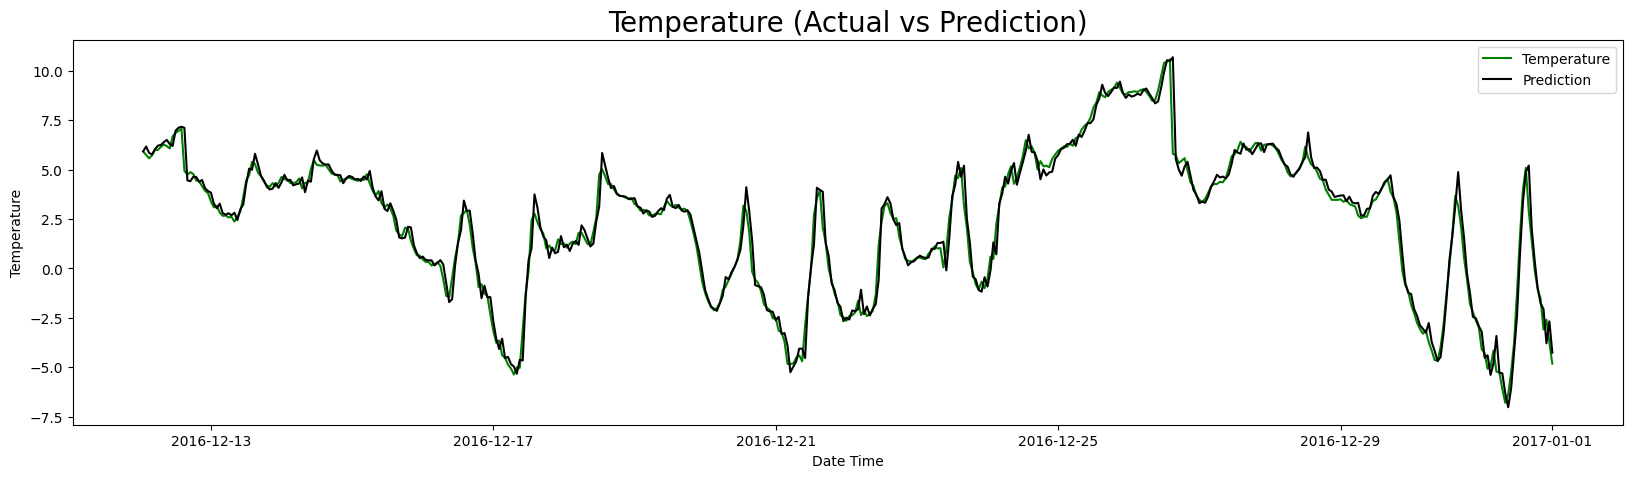

In [85]:
fig = plt.figure(figsize=(20,5))
sns.lineplot(data=df_result[-480:], x='Date Time', y='Temperature', label='Temperature', color='green')
sns.lineplot(data=df_result[-480:], x='Date Time', y='Prediction', label='Prediction', color='black')
plt.title('Temperature (Actual vs Prediction)', size=20)
plt.legend()
plt.show()

In [92]:
from sklearn.metrics import mean_absolute_error, mean_squared_error,mean_absolute_percentage_error

def mean_absolute_percentage_error(y_true, y_pred):
    # Avoid division by zero
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0
    return np.mean(np.abs((y_true[non_zero_indices] - y_pred[non_zero_indices]) / y_true[non_zero_indices])) * 100

def evaluate_model(y_true, y_pred):
    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_true, y_pred)

    # Mean Squared Error (MSE)
    mse = mean_squared_error(y_true, y_pred)

    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    # Mean Absolute Percentage Error (MAPE)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    print("This is based on the Test and actual")
    print("Mean Absolute Error (MAE): ", mae)
    print("Mean Squared Error (MSE): ", mse)
    print("Root Mean Squared Error (RMSE): ", rmse)
    print("Mean Absolute Percentage Error (MAPE): ", mape)
# Extract the actual and predicted values from df_result
y_true = df_result[-480:]['Temperature']
y_pred = df_result[-480:]['Prediction']

# Evaluate the model using the evaluation function
evaluate_model(y_true, y_pred)

This is based on the Test and actual
Mean Absolute Error (MAE):  0.3572243790378173
Mean Squared Error (MSE):  0.3024335815485523
Root Mean Squared Error (RMSE):  0.549939616274871
Mean Absolute Percentage Error (MAPE):  36.212349764475


GRU


In [95]:
import tensorflow as tf
from tensorflow.keras.optimizers.schedules import PolynomialDecay

# Define the GRU model
gru_model = tf.keras.Sequential([
    tf.keras.layers.GRU(128, input_shape=(window_len, len(input_.columns)), return_sequences=True),
    tf.keras.layers.ReLU(),
    tf.keras.layers.GRU(64, return_sequences=False),
    tf.keras.layers.Dense(1)
])

# Learning rate scheduler
num_epochs = 10
num_train_steps = len(train_gen) * num_epochs
lr_scheduler = PolynomialDecay(initial_learning_rate=1e-3, end_learning_rate=0.0, decay_steps=num_train_steps)

gru_model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(learning_rate=lr_scheduler),
                  metrics=[tf.metrics.RootMeanSquaredError()])

# Print model summary
gru_model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 24, 128)           54528     
                                                                 
 re_lu_6 (ReLU)              (None, 24, 128)           0         
                                                                 
 gru_1 (GRU)                 (None, 64)                37248     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 91841 (358.75 KB)
Trainable params: 91841 (358.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [96]:
early_stoping = EarlyStopping(monitor='val_loss',patience= 4,restore_best_weights=True,verbose=0)

gru_model.fit(
    x=train_gen,
    validation_data=val_gen,
    shuffle=False,
    callbacks=[early_stoping],
    batch_size=batch_size,
    epochs=num_epochs
    )

Epoch 1/10
3350/3350 [==============================] - 45s 12ms/step - loss: 4.9858 - root_mean_squared_error: 2.2329 - val_loss: 1.3448 - val_root_mean_squared_error: 1.1596
Epoch 2/10
3350/3350 [==============================] - 35s 11ms/step - loss: 1.2555 - root_mean_squared_error: 1.1205 - val_loss: 0.8118 - val_root_mean_squared_error: 0.9010
Epoch 3/10
3350/3350 [==============================] - 32s 9ms/step - loss: 0.8586 - root_mean_squared_error: 0.9266 - val_loss: 0.7557 - val_root_mean_squared_error: 0.8693
Epoch 4/10
3350/3350 [==============================] - 33s 10ms/step - loss: 0.7412 - root_mean_squared_error: 0.8610 - val_loss: 0.6830 - val_root_mean_squared_error: 0.8264
Epoch 5/10
3350/3350 [==============================] - 26s 8ms/step - loss: 0.6445 - root_mean_squared_error: 0.8028 - val_loss: 0.7035 - val_root_mean_squared_error: 0.8388
Epoch 6/10
3350/3350 [==============================] - 26s 8ms/step - loss: 0.5681 - root_mean_squared_error: 0.7537 - va

In [109]:
# save model
gru_model.save('multi_gru_temperature.h5')

# load model
Gru_model = tf.keras.models.load_model('multi_gru_temperature.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [110]:
pred2 = Gru_model.predict(test_gen).flatten()

437/437 [==============================] - 2s 3ms/step


In [111]:
pred2

array([ 0.9275722 ,  0.94572276,  0.93465716, ..., -3.463339  ,
       -2.4392717 , -3.8326695 ], dtype=float32)

In [112]:
df_result = X_test[window_len:].copy()
df_result['pred2'] =  pred2
df_result['Date Time'] = df['Date Time'][X_test.index[0]:].copy()
df_result = df_result[['Date Time','T (degC)','pred2']].set_axis(['Date Time', 'Temperature', 'Prediction'],axis=1)
df_result.head()

,Date Time,Temperature,Prediction
63106,2016-12-03 21:00:00,0.87,0.927572
63107,2016-12-03 22:00:00,0.88,0.945723
63108,2016-12-03 23:00:00,0.93,0.934657
63109,2016-03-13 00:00:00,1.07,0.930573
63110,2016-03-13 01:00:00,1.07,1.169017


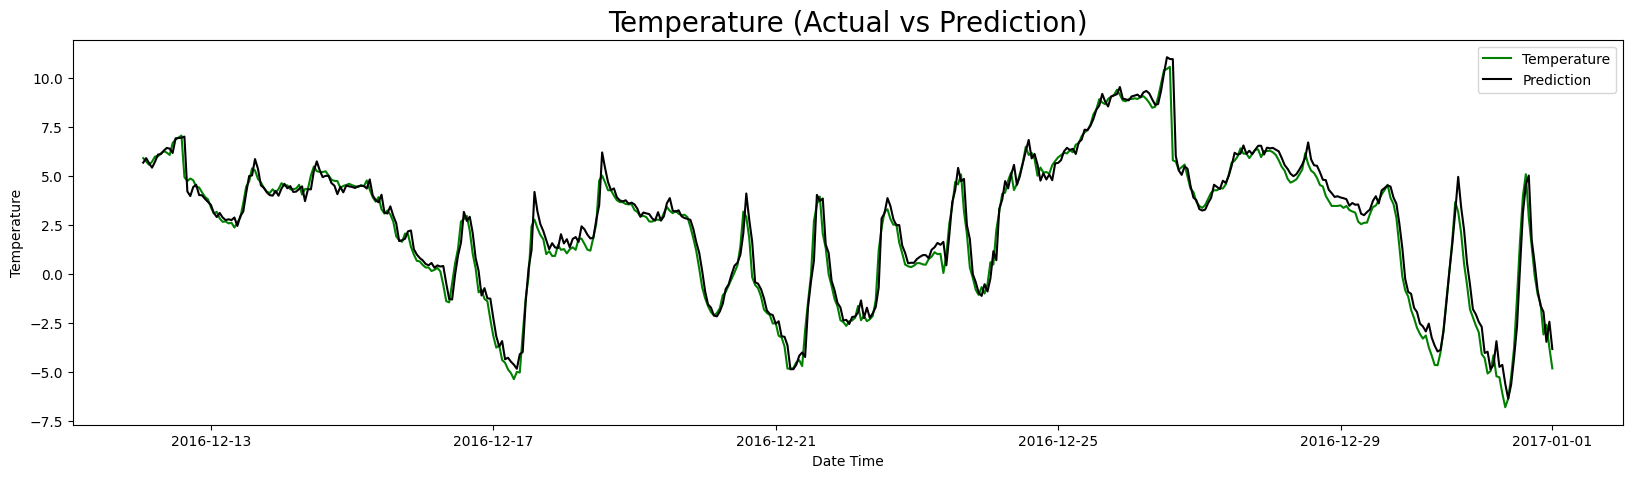

In [113]:
fig = plt.figure(figsize=(20,5))
sns.lineplot(data=df_result[-480:], x='Date Time', y='Temperature', label='Temperature', color='green')
sns.lineplot(data=df_result[-480:], x='Date Time', y='Prediction', label='Prediction', color='black')
plt.title('Temperature (Actual vs Prediction)', size=20)
plt.legend()
plt.show()

In [114]:
from sklearn.metrics import mean_absolute_error, mean_squared_error,mean_absolute_percentage_error

def mean_absolute_percentage_error(y_true, y_pred):
    # Avoid division by zero
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0
    return np.mean(np.abs((y_true[non_zero_indices] - y_pred[non_zero_indices]) / y_true[non_zero_indices])) * 100

def evaluate_model(y_true, y_pred):
    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_true, y_pred)

    # Mean Squared Error (MSE)
    mse = mean_squared_error(y_true, y_pred)

    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    # Mean Absolute Percentage Error (MAPE)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    print("This is based on the Test and actual")
    print("Mean Absolute Error (MAE): ", mae)
    print("Mean Squared Error (MSE): ", mse)
    print("Root Mean Squared Error (RMSE): ", rmse)
    print("Mean Absolute Percentage Error (MAPE): ", mape)
# Extract the actual and predicted values from df_result
y_true = df_result[-480:]['Temperature']
y_pred = df_result[-480:]['Prediction']

# Evaluate the model using the evaluation function
evaluate_model(y_true, y_pred)

This is based on the Test and actual
Mean Absolute Error (MAE):  0.4259583759705226
Mean Squared Error (MSE):  0.38323208218905486
Root Mean Squared Error (RMSE):  0.6190574142913199
Mean Absolute Percentage Error (MAPE):  49.851025980427345


CNN

In [120]:
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_len,len(input_.columns))),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Learning rate scheduler
cnn_model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(learning_rate=lr_scheduler),
                  metrics=[tf.metrics.RootMeanSquaredError()])

# Print model summary
cnn_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 22, 64)            2368      
                                                                 
 conv1d_1 (Conv1D)           (None, 20, 64)            12352     
                                                                 
 max_pooling1d (MaxPooling1  (None, 10, 64)            0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 640)               0         
                                                                 
 dense_6 (Dense)             (None, 50)                32050     
                                                                 
 dense_7 (Dense)             (None, 1)                 51        
                                                      

In [122]:
early_stoping = EarlyStopping(monitor='val_loss',patience= 4,restore_best_weights=True,verbose=0)

cnn_model.fit(
    x=train_gen,
    validation_data=val_gen,
    shuffle=False,
    callbacks=[early_stoping],
    batch_size=batch_size,
    epochs=num_epochs
    )

Epoch 1/10
3350/3350 [==============================] - 19s 6ms/step - loss: 1.5374 - root_mean_squared_error: 1.2399 - val_loss: 3027.9038 - val_root_mean_squared_error: 55.0264
Epoch 2/10
3350/3350 [==============================] - 22s 6ms/step - loss: 1.0822 - root_mean_squared_error: 1.0403 - val_loss: 1652.3469 - val_root_mean_squared_error: 40.6491
Epoch 3/10
3350/3350 [==============================] - 17s 5ms/step - loss: 0.8790 - root_mean_squared_error: 0.9376 - val_loss: 1176.4413 - val_root_mean_squared_error: 34.2993
Epoch 4/10
3350/3350 [==============================] - 20s 6ms/step - loss: 0.7674 - root_mean_squared_error: 0.8760 - val_loss: 817.8903 - val_root_mean_squared_error: 28.5988
Epoch 5/10
3350/3350 [==============================] - 17s 5ms/step - loss: 0.6825 - root_mean_squared_error: 0.8261 - val_loss: 873.4299 - val_root_mean_squared_error: 29.5538
Epoch 6/10
3350/3350 [==============================] - 16s 5ms/step - loss: 0.6096 - root_mean_squared_err

In [123]:
# save model
cnn_model.save('multi_cnn_temperature.h5')

# load model
cnn_model = tf.keras.models.load_model('multi_cnn_temperature.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [124]:
pred3 = cnn_model.predict(test_gen).flatten()

437/437 [==============================] - 1s 2ms/step


In [125]:
df_result = X_test[window_len:].copy()
df_result['pred3'] =  pred3
df_result['Date Time'] = df['Date Time'][X_test.index[0]:].copy()
df_result = df_result[['Date Time','T (degC)','pred3']].set_axis(['Date Time', 'Temperature', 'Prediction'],axis=1)
df_result.head()

,Date Time,Temperature,Prediction
63106,2016-12-03 21:00:00,0.87,0.802427
63107,2016-12-03 22:00:00,0.88,0.681628
63108,2016-12-03 23:00:00,0.93,0.770810
63109,2016-03-13 00:00:00,1.07,0.966079
63110,2016-03-13 01:00:00,1.07,1.144912


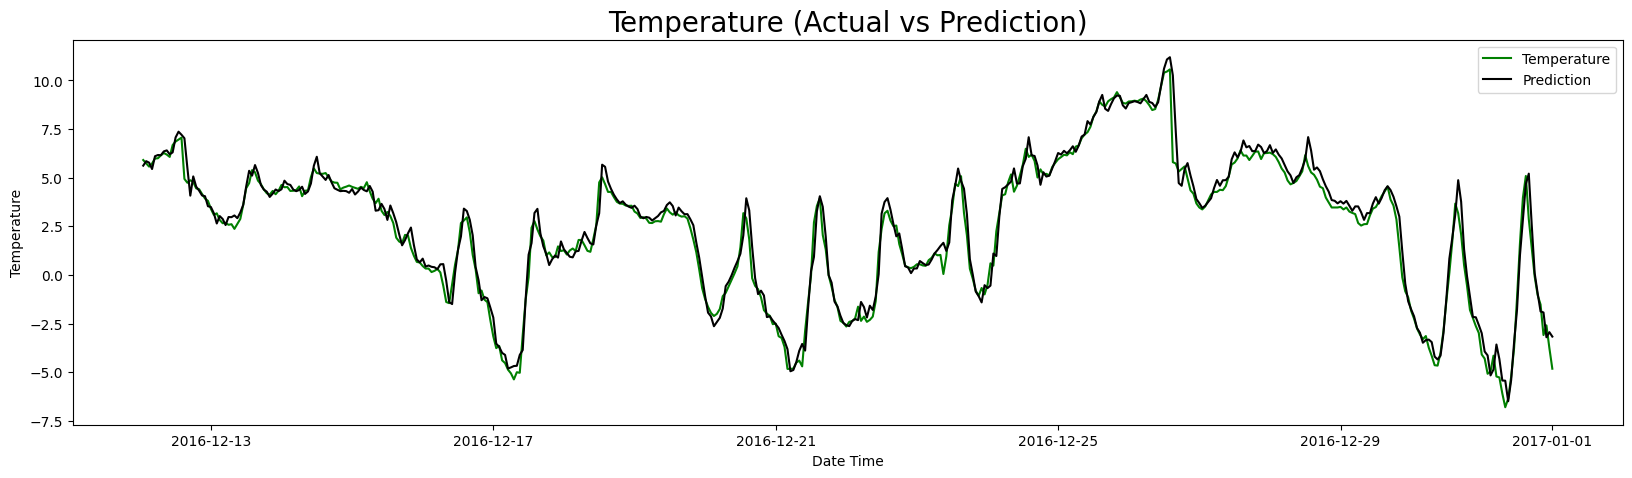

In [126]:
fig = plt.figure(figsize=(20,5))
sns.lineplot(data=df_result[-480:], x='Date Time', y='Temperature', label='Temperature', color='green')
sns.lineplot(data=df_result[-480:], x='Date Time', y='Prediction', label='Prediction', color='black')
plt.title('Temperature (Actual vs Prediction)', size=20)
plt.legend()
plt.show()

In [127]:
from sklearn.metrics import mean_absolute_error, mean_squared_error,mean_absolute_percentage_error

def mean_absolute_percentage_error(y_true, y_pred):
    # Avoid division by zero
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0
    return np.mean(np.abs((y_true[non_zero_indices] - y_pred[non_zero_indices]) / y_true[non_zero_indices])) * 100

def evaluate_model(y_true, y_pred):
    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_true, y_pred)

    # Mean Squared Error (MSE)
    mse = mean_squared_error(y_true, y_pred)

    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    # Mean Absolute Percentage Error (MAPE)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    print("This is based on the Test and actual")
    print("Mean Absolute Error (MAE): ", mae)
    print("Mean Squared Error (MSE): ", mse)
    print("Root Mean Squared Error (RMSE): ", rmse)
    print("Mean Absolute Percentage Error (MAPE): ", mape)
# Extract the actual and predicted values from df_result
y_true = df_result[-480:]['Temperature']
y_pred = df_result[-480:]['Prediction']

# Evaluate the model using the evaluation function
evaluate_model(y_true, y_pred)

This is based on the Test and actual
Mean Absolute Error (MAE):  0.39857365599150457
Mean Squared Error (MSE):  0.3350742973008736
Root Mean Squared Error (RMSE):  0.578856024673557
Mean Absolute Percentage Error (MAPE):  35.79426598052367
